In [ ]:
# -*- coding: utf-8 -*-
"""

Code for training an artificial neural network (ANN)
to compare to the neuromorphic device based on linear scattering

Requirements: numpy, jax, tensorflow, keras, os

NOTE:
The training and test set data (optdigits.tra and optdigits.tes) need to be downloaded.
The path of these files can be changed below.

C. Wanjura and F. Marquardt
2023/24, MIT License
"""

In [ ]:
## Import necessary libraries
import os

import numpy as np
from numpy import loadtxt

import matplotlib.pyplot as plt

import jax.numpy as jnp

import tensorflow as tf
import keras

load data

In [ ]:
''''
change to path containing the files optdigits.tra and optdigits.tes
'''

os.chdir("/")

In [ ]:
lines = loadtxt("optdigits.tra", comments="#", delimiter=",", unpack=False)
lines_test = loadtxt("optdigits.tes", comments="#", delimiter=",", unpack=False)

In [ ]:
## rescale image data: white pixles (background) are set to a detuning of 5, black pixels (foreground, numerals) are set to a detuning of 0 (resonant)

## training images
x_train_vect = jnp.complex64(jnp.array(5*(1 - (lines[:,0:64])/16)))
y_train = np.array(lines[:,64], dtype = int)
y_train_vect = jnp.zeros((len(lines),10))
for jj in range(len(y_train)):
    y_train_vect = y_train_vect.at[jj, int(y_train[jj])].set(1.0)
y_train_vect = jnp.complex64(y_train_vect)

## test images
x_test_vect = jnp.complex64(jnp.array(5*(1 - (lines_test[:,0:64])/16)))
y_test = np.array(lines_test[:,64], dtype = int)
y_test_vect = jnp.zeros((len(lines_test),10))
for jj in range(len(y_test)):
    y_test_vect = y_test_vect.at[jj, int(y_test[jj])].set(1.0)
y_test_vect = jnp.complex64(y_test_vect)

In [ ]:
## NOTE: all physical parameters are expressed in units of the uniform decay rate kappa

In [ ]:
## Import necessary libraries
import os

import numpy as np
from numpy import loadtxt

import time

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
from jax.scipy.linalg import expm
from jax import random

## key for random number generation with jax
key = random.PRNGKey(0)

load data

In [ ]:
lines = loadtxt("optdigits.tra", comments="#", delimiter=",", unpack=False)
lines_test = loadtxt("optdigits.tes", comments="#", delimiter=",", unpack=False)

In [ ]:
## rescale image data: white pixles (background) are set to 5, black pixels (foreground, numerals) are set to a detuning of 0 (resonant)
## this is the same as for the images used to train the neuromorphic network.
## Surprisingly, this also leads to a better performance (1-2 % better test accuracy) for ANNs compared to setting white pixels to 0, black pixels to 1.

## training images
x_train_vect = jnp.complex64(jnp.array(5*(1 - (lines[:,0:64])/16)))
y_train = np.array(lines[:,64], dtype = int)
y_train_vect = jnp.zeros((len(lines),10))
for jj in range(len(y_train)):
    y_train_vect = y_train_vect.at[jj, int(y_train[jj])].set(1.0)
y_train_vect = jnp.complex64(y_train_vect)

## test images
x_test_vect = jnp.complex64(jnp.array(5*(1 - (lines_test[:,0:64])/16)))
y_test = np.array(lines_test[:,64], dtype = int)
y_test_vect = jnp.zeros((len(lines_test),10))
for jj in range(len(y_test)):
    y_test_vect = y_test_vect.at[jj, int(y_test[jj])].set(1.0)
y_test_vect = jnp.complex64(y_test_vect)

linear classifier (same number of parameters as neuromorphic system with N0 = 128, N1 = 80, N2 = 10)

In [ ]:
## this linear classifier with 150 neurons in the hidden layer has the same number of parameters as the neuromorphic system with N0 = 128, N1 = 80, N2 = 10

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(150, input_shape=(64,),activation='linear'))
model.add(tf.keras.layers.Dense(10,activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=['accuracy'],
              loss=tf.keras.losses.MeanSquaredError() ## mean-squared error cost function to extract only linear aspects
              )

In [ ]:
history = model.fit(
    x_train_vect,
    y_train_vect,
    batch_size=200,
    epochs=5000,
    validation_data=(x_test_vect, y_test_vect)) ## evaluates the test accuracy during the training

Epoch 1/5000


20/20 [==============================] - 0s 3ms/step - loss: 2.7799 - accuracy: 0.0950 - val_loss: 0.8174 - val_accuracy: 0.1269
Epoch 2/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.6630 - accuracy: 0.1787 - val_loss: 0.4454 - val_accuracy: 0.2460
Epoch 3/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.3417 - accuracy: 0.3152 - val_loss: 0.2820 - val_accuracy: 0.3434
Epoch 4/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.2267 - accuracy: 0.4065 - val_loss: 0.2094 - val_accuracy: 0.4151
Epoch 5/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.1728 - accuracy: 0.4868 - val_loss: 0.1665 - val_accuracy: 0.5075
Epoch 6/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.1420 - accuracy: 0.5579 - val_loss: 0.1389 - val_accuracy: 0.5743
Epoch 7/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.1188 - accuracy: 0.6301 - val_loss: 0.1225 - val_accuracy: 0.6066
Epoch 8/5000
20/20 

In [ ]:
np.sum(np.argmax(model(x_train_vect), axis = 1) == y_train) / len(y_train)

0.9356526288255297

In [ ]:
np.sum(np.argmax(model(x_test_vect), axis = 1) == y_test) / len(y_test)

0.9165275459098498

(0.9, 1.0)

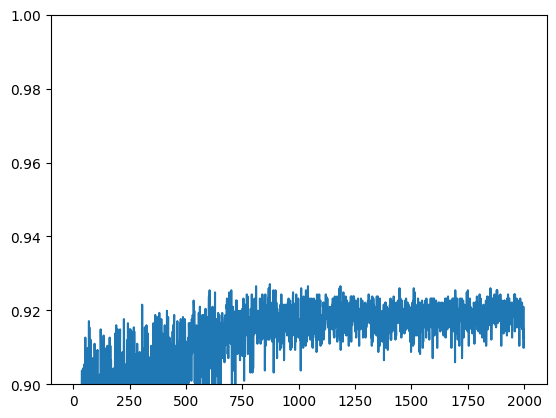

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.ylim([.9,1])

In [ ]:
np.savetxt("ANN_test-accuracy_linearClassifier.csv", history.history['val_accuracy'], delimiter=",")

ANN (same number of parameters as neuromorphic system with N0 = 128, N1 = 80, N2 = 10)

In [ ]:
## this linear classifier with 150 neurons in the hidden layer has the same number of parameters as the neuromorphic system with N0 = 128, N1 = 80, N2 = 10

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(150, input_shape=(64,),activation='sigmoid'))
model.add(tf.keras.layers.Dense(10,activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),metrics=['accuracy'],
              loss=tf.keras.losses.sparse_categorical_crossentropy
              )

In [ ]:
history = model.fit(x_train_vect, y_train, batch_size=200, epochs=5000, validation_data=(x_test_vect, y_test)) ## evaluates the test accuracy during the training

Epoch 1/5000


20/20 [==============================] - 0s 3ms/step - loss: 2.0392 - accuracy: 0.4175 - val_loss: 1.7819 - val_accuracy: 0.4096
Epoch 2/5000
20/20 [==============================] - 0s 1ms/step - loss: 1.4462 - accuracy: 0.7913 - val_loss: 1.4864 - val_accuracy: 0.3600
Epoch 3/5000
20/20 [==============================] - 0s 1ms/step - loss: 1.0657 - accuracy: 0.8601 - val_loss: 1.0632 - val_accuracy: 0.7195
Epoch 4/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.8081 - accuracy: 0.8959 - val_loss: 0.8081 - val_accuracy: 0.8403
Epoch 5/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.6462 - accuracy: 0.9197 - val_loss: 0.6520 - val_accuracy: 0.8809
Epoch 6/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.5367 - accuracy: 0.9304 - val_loss: 0.5589 - val_accuracy: 0.8959
Epoch 7/5000
20/20 [==============================] - 0s 1ms/step - loss: 0.4606 - accuracy: 0.9336 - val_loss: 0.5046 - val_accuracy: 0.9032
Epoch 8/5000
20/20 

(0.9, 1.0)

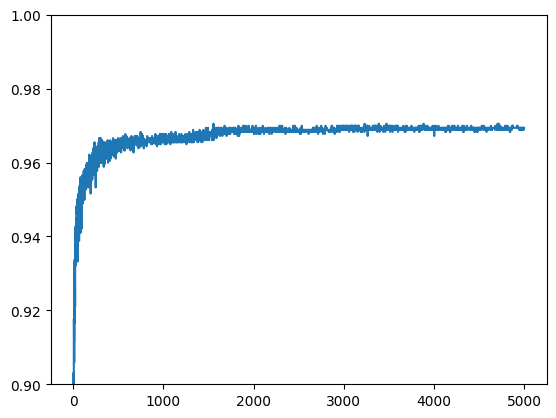

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.ylim([.9,1])

In [ ]:
np.max(history.history['val_accuracy'])

0.9705063700675964

In [ ]:
np.savetxt("ANN_test-accuracy_SGD.csv", history.history['val_accuracy'], delimiter=",")

ANN for comparison to the N1 = 300 neuromorphic case

In [ ]:
## this ANN with 560 neurons in the hidden layer has the same number of parameters as the neuromorphic system with N0 = 128, N1 = 300, N2 = 10

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(560, input_shape=(64,),activation='sigmoid'))
model.add(tf.keras.layers.Dense(10,activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=['accuracy'],
              loss=tf.keras.losses.CategoricalCrossentropy()
              )

In [ ]:
history = model.fit(
    x_train_vect,
    y_train_vect,
    batch_size=200,
    epochs=5000,
    validation_data=(x_test_vect, y_test_vect))

Epoch 1/5000


20/20 [==============================] - 0s 4ms/step - loss: 1.7896 - accuracy: 0.5116 - val_loss: 1.2551 - val_accuracy: 0.8397
Epoch 2/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.9161 - accuracy: 0.9022 - val_loss: 0.7074 - val_accuracy: 0.8737
Epoch 3/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.5323 - accuracy: 0.9289 - val_loss: 0.4993 - val_accuracy: 0.9015
Epoch 4/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.3755 - accuracy: 0.9362 - val_loss: 0.3925 - val_accuracy: 0.9126
Epoch 5/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.3001 - accuracy: 0.9440 - val_loss: 0.3344 - val_accuracy: 0.9199
Epoch 6/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.9516 - val_loss: 0.3058 - val_accuracy: 0.9188
Epoch 7/5000
20/20 [==============================] - 0s 2ms/step - loss: 0.2214 - accuracy: 0.9563 - val_loss: 0.2867 - val_accuracy: 0.9182
Epoch 8/5000
20/20 

In [ ]:
np.sum(np.argmax(model(x_train_vect), axis = 1) == y_train) / len(y_train)

1.0

In [ ]:
np.sum(np.argmax(model(x_test_vect), axis = 1) == y_test) / len(y_test)

0.9705063995548135

(0.9, 1.0)

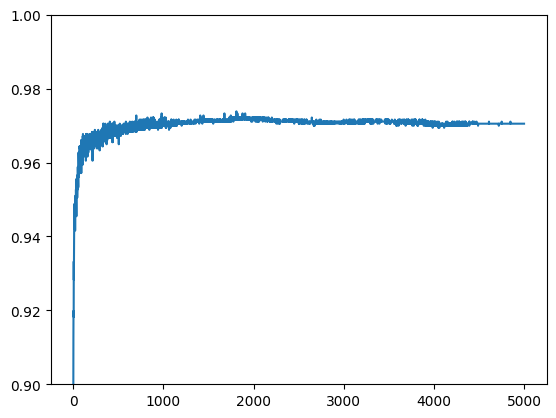

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.ylim([.9,1])

In [ ]:
np.savetxt("ANN_test-accuracy_non-linear_560.csv", history.history['val_accuracy'], delimiter=",")

convolutional network, 5x5 kernel

In [ ]:
import tensorflow as tf
import keras

In [ ]:
## reshape data

x_train = x_train_vect.reshape((3823, 8, 8))
x_test = x_test_vect.reshape((1797, 8, 8))

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train.shape

In [ ]:
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [ ]:
num_classes = 10

model = tf.keras.Sequential()

model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(8,8,1)))
model.add(keras.layers.AveragePooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(120, activation='relu'))

model.add(keras.layers.Dense(84, activation='relu'))

model.add(keras.layers.Dense(num_classes, activation = 'softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 4, 4, 6)           156       
                                                                 
 average_pooling2d_17 (Aver  (None, 2, 2, 6)           0         
 agePooling2D)                                                   
                                                                 
 flatten_13 (Flatten)        (None, 24)                0         
                                                                 
 dense_39 (Dense)            (None, 120)               3000      
                                                                 
 dense_40 (Dense)            (None, 84)                10164     
                                                                 
 dense_41 (Dense)            (None, 10)                850       
                                                     

In [ ]:
history = model.fit(x_train, y_train, batch_size=20, epochs=5000, validation_data=(x_test, y_test))

Epoch 1/5000


192/192 [==============================] - 0s 857us/step - loss: 1.3765 - accuracy: 0.5577 - val_loss: 1.6893 - val_accuracy: 0.5225
Epoch 2/5000
192/192 [==============================] - 0s 523us/step - loss: 0.3906 - accuracy: 0.8739 - val_loss: 2.6160 - val_accuracy: 0.5186
Epoch 3/5000
192/192 [==============================] - 0s 514us/step - loss: 0.2402 - accuracy: 0.9231 - val_loss: 0.2705 - val_accuracy: 0.9015
Epoch 4/5000
192/192 [==============================] - 0s 532us/step - loss: 0.1680 - accuracy: 0.9482 - val_loss: 0.2301 - val_accuracy: 0.9265
Epoch 5/5000
192/192 [==============================] - 0s 530us/step - loss: 0.1478 - accuracy: 0.9563 - val_loss: 0.2361 - val_accuracy: 0.9327
Epoch 6/5000
192/192 [==============================] - 0s 539us/step - loss: 0.1294 - accuracy: 0.9615 - val_loss: 0.5320 - val_accuracy: 0.8625
Epoch 7/5000
192/192 [==============================] - 0s 542us/step - loss: 0.1160 - accuracy: 0.9631 - val_loss: 0.2184 - val_accuracy

(0.9, 1.0)

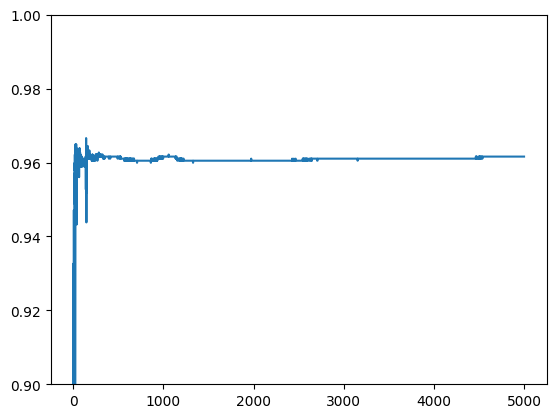

In [ ]:
plt.plot(history.history['val_accuracy'])

plt.ylim([.9,1])

In [ ]:
np.max(history.history['val_accuracy'])

0.9666110277175903

In [ ]:
np.savetxt("ANN_test-accuracy_convolutional.csv", history.history['val_accuracy'], delimiter=",")

convolutional network 5x5 kernel, training with Adam

In [ ]:
num_classes = 10

model = tf.keras.Sequential()

model.add(keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(8,8,1)))
model.add(keras.layers.AveragePooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(120, activation='relu'))

model.add(keras.layers.Dense(84, activation='relu'))

model.add(keras.layers.Dense(num_classes, activation = 'softmax'))

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 4, 4, 6)           156       
                                                                 
 average_pooling2d_15 (Aver  (None, 2, 2, 6)           0         
 agePooling2D)                                                   
                                                                 
 flatten_11 (Flatten)        (None, 24)                0         
                                                                 
 dense_33 (Dense)            (None, 120)               3000      
                                                                 
 dense_34 (Dense)            (None, 84)                10164     
                                                                 
 dense_35 (Dense)            (None, 10)                850       
                                                     

In [ ]:
history = model.fit(x_train, y_train, batch_size=20, epochs=5000, validation_data=(x_test, y_test))

Epoch 1/5000


192/192 [==============================] - 0s 834us/step - loss: 2.2954 - accuracy: 0.1169 - val_loss: 2.2795 - val_accuracy: 0.2632
Epoch 2/5000
192/192 [==============================] - 0s 515us/step - loss: 2.2650 - accuracy: 0.3403 - val_loss: 2.2456 - val_accuracy: 0.3734
Epoch 3/5000
192/192 [==============================] - 0s 509us/step - loss: 2.2138 - accuracy: 0.3965 - val_loss: 2.1718 - val_accuracy: 0.4274
Epoch 4/5000
192/192 [==============================] - 0s 527us/step - loss: 2.0885 - accuracy: 0.4491 - val_loss: 1.9826 - val_accuracy: 0.4819
Epoch 5/5000
192/192 [==============================] - 0s 524us/step - loss: 1.7741 - accuracy: 0.5218 - val_loss: 1.5795 - val_accuracy: 0.5392
Epoch 6/5000
192/192 [==============================] - 0s 530us/step - loss: 1.2795 - accuracy: 0.6620 - val_loss: 1.0982 - val_accuracy: 0.6895
Epoch 7/5000
192/192 [==============================] - 0s 539us/step - loss: 0.9158 - accuracy: 0.7526 - val_loss: 0.8645 - val_accuracy

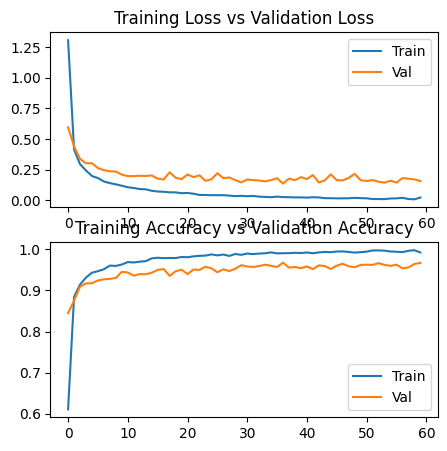

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(5,5))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
np.sum(np.argmax(model(x_train), axis = 1) == y_train) / len(y_train)

0.9992152759612869

In [ ]:
np.sum(np.argmax(model(x_test), axis = 1) == y_test) / len(y_test)

0.9671675013912076

convolutional network, 3x3 kernel, training with Adam

In [ ]:
num_classes = 10

model = tf.keras.Sequential()

model.add(keras.layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(8,8,1)))
model.add(keras.layers.AveragePooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(120, activation='relu'))

model.add(keras.layers.Dense(84, activation='relu'))

model.add(keras.layers.Dense(num_classes, activation = 'softmax'))

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 6, 6, 6)           60        
                                                                 
 average_pooling2d_12 (Aver  (None, 3, 3, 6)           0         
 agePooling2D)                                                   
                                                                 
 flatten_8 (Flatten)         (None, 54)                0         
                                                                 
 dense_24 (Dense)            (None, 120)               6600      
                                                                 
 dense_25 (Dense)            (None, 84)                10164     
                                                                 
 dense_26 (Dense)            (None, 10)                850       
                                                     

In [ ]:
history = model.fit(x_train, y_train, batch_size=20, epochs=60, validation_data=(x_test, y_test))

Epoch 1/60


192/192 [==============================] - 0s 1ms/step - loss: 1.1720 - accuracy: 0.6966 - val_loss: 0.3837 - val_accuracy: 0.8870
Epoch 2/60
192/192 [==============================] - 0s 864us/step - loss: 0.2562 - accuracy: 0.9328 - val_loss: 0.2912 - val_accuracy: 0.9048
Epoch 3/60
192/192 [==============================] - 0s 879us/step - loss: 0.1934 - accuracy: 0.9411 - val_loss: 0.2505 - val_accuracy: 0.9188
Epoch 4/60
192/192 [==============================] - 0s 862us/step - loss: 0.1583 - accuracy: 0.9524 - val_loss: 0.2185 - val_accuracy: 0.9260
Epoch 5/60
192/192 [==============================] - 0s 853us/step - loss: 0.1419 - accuracy: 0.9592 - val_loss: 0.2070 - val_accuracy: 0.9410
Epoch 6/60
192/192 [==============================] - 0s 855us/step - loss: 0.1190 - accuracy: 0.9668 - val_loss: 0.2793 - val_accuracy: 0.9082
Epoch 7/60
192/192 [==============================] - 0s 870us/step - loss: 0.1173 - accuracy: 0.9683 - val_loss: 0.1857 - val_accuracy: 0.9427
Epoch

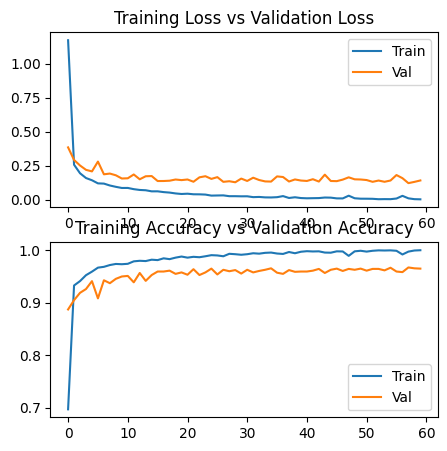

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(5,5))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
np.sum(np.argmax(model(x_train), axis = 1) == y_train) / len(y_train)

1.0

In [ ]:
np.sum(np.argmax(model(x_test), axis = 1) == y_test) / len(y_test)

0.9649415692821369